<a href="https://colab.research.google.com/github/jogabenn/Advanced-Machine-Learning-Methods-Activities/blob/main/Activity%202a/A2a_DL_TC5033_AD2023_A01793038.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

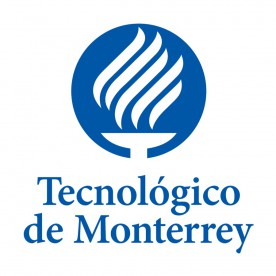

# **Master in Applied Artificial Intelligence**
## **Course: Advanced Machine Learning Methods**
### Tecnológico de Monterrey
### José Antonio Cantoral Ceballos, Ph.D.

## **Activity 2a: Implementing a FC for ASL Dataset Using PyTorch**

Jonathan Garza Bennet | A01793038

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks using PyTorch
<br>

#### Activity 2a: Implementing a FC for ASL Dataset using PyTorch
<br>


- Objective

    The primary aim of this activity is to transition from using Numpy for network implementation to utilizing PyTorch, a powerful deep learning framework. You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
- Instructions

    Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.

    Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

    Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset.

    Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like nn.Linear() and nn.ReLU().

    Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.

    Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

In [1]:
#Importing required modules for the excercise
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

# Only for Jupyter Themes users
#from jupyterthemes import jtplot
#jtplot.style(grid=False)

In [2]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
#DATA_PATH = '/home/pepe/Documents/github_repos/datasets/asl_data'

#Updated route to Kaggle ASL dataset
DATA_PATH = '/content/asl_data/'

#Asign training and validation partions directly from the dataset
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### Always a good idea to explore the data

In [3]:
#Show training partition head
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Get training label data

In [4]:
#Assign data labels to new variables
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

#Delete the label columns from Pandas data frame
del train_df['label']
del valid_df['label']

#Assign pixel values to new variables as float32 type
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
#Print shapes to that new variables are correct
print(x_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [6]:
#Print shapes to that new variables are correct
print(x_val.shape, y_val.shape)

(7172, 784) (7172,)


In [7]:
#Function to split the validation and test partitions
def split_val_test(x, y, pct=0.5, shuffle=True):

    #Check if the lengths are the same before proceeding
    assert x.shape[0] == y.shape[0], 'Number of samples x!= number samples y'
    total_samples = x.shape[0]

    #If shuffle is enabled resort the data randomly
    if shuffle:
        idxs = np.arange(x.shape[0])
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        #return x_val, y_val, x_test, y_test
#         return x[:total_samples//2, :], y[:total_samples//2], x[total_samples//2:, :], y[total_samples//2:]

    #Apply partition percentage factor to the data length, round it and return splitted partitions
    return x[:int(total_samples*pct), :], y[:int(total_samples*pct)], x[int(total_samples*(pct)):, :], y[int(total_samples*(pct)):]


In [8]:
#Split validation and test partitions by default value
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [9]:
#Check the type of data for veryfing that is correct
type(y_val)

numpy.ndarray

In [10]:
#Print data shapes so they are correct
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3586, 784) (3586,)
(3586, 784) (3586,)


In [11]:
#Create a list form with the ascii alphabet
alphabet=list(string.ascii_lowercase)

#Exclude 'j' and 'z'
alphabet.remove('j')
alphabet.remove('z')

#Print alphabet and its length
print(alphabet)
print(len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
24


### Normalise the data

In [12]:
#Function for normalizing the dataset
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [13]:
#Normalization parameters
x_mean = x_train.mean()
x_std = x_train.std()

#Dataset normalization with parameters calculated before
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)


In [14]:
#Display results
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

The normalization process improves training efficiency and avoids the data with higher mangnitude to get more relevant when it is really not. After normalization, the new data average is 0 and the standard deviation is 1.

### Plotting Image Samples

In [15]:
#Function to display a data set letter image
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

The image displayed represents: p


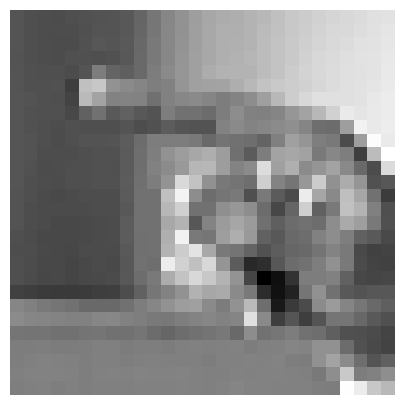

In [45]:
#Print a random number to test the code and visualize the dataset
rnd_idx = np.random.randint(len(y_val))
print(f'The image displayed represents: {alphabet[y_val[rnd_idx]]}')
plot_number(x_val[rnd_idx].reshape(28,28))

### The model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Create minibatches

In [17]:
#Function to create training minibatches
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #samples, 784
    y #samples, 1
    '''
    #Check if the lengths are the same before proceeding
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]

    #If shuffle is enabled resort the data randomly
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    #return data in the desired minibatch data increments
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [18]:
#Visualize the total number of minibatches that are created after calling the functions
for i, (x, y) in enumerate(create_minibatches(128,x_train, y_train)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


### Now the PyTorch part

In [19]:
#Convert the data partitions into PyTorch tensors so they can be used by the module
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

In [20]:
#Use GPU for faster learning if available
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Use CPU for not requiring Colab Pro
device = 'cpu'
print(device)

cpu


### Accuracy

In [21]:
#Function to calculate the model accuracy
def accuracy(model, x, y, mb_size):
    #Initialize model metrics to 0
    num_correct = 0
    num_total = 0
    cost = 0.

    #Evaluate model
    model.eval()

    #Assign it to current processing device
    model = model.to(device=device)
    with torch.no_grad():

        #Evaluate the model on each of the minibatches created
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x, y),1):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)

            #Calculate scores and cost of current minibatch
            scores = model(xi) # mb_size, 10
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) #pred shape (mb_size )

            #Accumulate the total correct and total elements
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        #Return average cost and accuracy
        return cost/mb, float(num_correct)/num_total

### Training Loop

In [22]:
#Function for training the model
def train(model, optimiser, mb_size, epochs=100):

    #Assign model to current processing unit
    model = model.to(device=device)

    #Initialize model metrics
    train_cost = 0.
    val_cost = 0.

    #Epoch loop
    for epoch in range(epochs):

        #Initialize model metrics for current loop
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0

        #Train the model on each of the minibatches created
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x_train_tensor, y_train_tensor), 1):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())

            #Reset gradients
            optimiser.zero_grad()

            #Calculate gradients
            cost.backward()

            #Update hyperparameters
            optimiser.step()

            #Accumulate total correct predictions
            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()

            #Accumulate total elements reviewed
            train_total += scores.size(0)

            #Accumulate total cost
            train_cost_acum += cost.item()

        #Calculate cost and accuracy for the validation partition
        val_cost, val_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)

        #Calculate cost and accuracy for the training partition
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        #if epoch%20 == 0:
        if epoch == epoch:
            print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')


### Model using Sequential

Model 1 Original Hyperparameters

In [31]:
#Model instances
# hidden1 = 100

#Hyperparameters
hidden = 200
lr = 1e-3
epochs = 100
mb_size = 128

#Input and output size element calculation
in_features = x_test_tensor.size()[1]
out_features = len(alphabet)

#Model definition with dropout to avoid overfitting
model1 = nn.Sequential(nn.Linear(in_features = in_features, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=hidden), nn.ReLU(), nn.Dropout(),
#                       nn.Linear(in_features=hidden, out_features=hidden), nn.ReLU(), nn.Dropout(),
                       nn.Linear(in_features=hidden, out_features = out_features))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)

#Optimize model parameters using Adam with current learning rate and weight decay furthermore avoid overfitting
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=5e-3)

#Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

#Train the model
train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 1.470125, val cost: 1.015204, train acc: 0.5265, val acc: 0.649749, lr: 0.004000
Epoch:1, train cost: 0.914701, val cost: 0.907717, train acc: 0.6993, val acc: 0.691299, lr: 0.004000
Epoch:2, train cost: 0.799787, val cost: 0.753727, train acc: 0.7362, val acc: 0.743726, lr: 0.004000
Epoch:3, train cost: 0.767215, val cost: 0.741600, train acc: 0.7486, val acc: 0.750139, lr: 0.004000
Epoch:4, train cost: 0.738468, val cost: 0.826450, train acc: 0.7602, val acc: 0.731177, lr: 0.004000
Epoch:5, train cost: 0.721642, val cost: 0.812419, train acc: 0.7643, val acc: 0.724205, lr: 0.004000
Epoch:6, train cost: 0.733297, val cost: 0.762596, train acc: 0.7653, val acc: 0.753207, lr: 0.004000
Epoch:7, train cost: 0.687459, val cost: 0.783615, train acc: 0.7761, val acc: 0.733408, lr: 0.004000
Epoch:8, train cost: 0.697066, val cost: 0.868132, train acc: 0.7736, val acc: 0.691578, lr: 0.004000
Epoch:9, train cost: 0.710455, val cost: 0.899229, train acc: 0.7704, val acc: 0.7

In [32]:
#Calculate model accuracy
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)[1]

0.7306190741773564

***The model is showing the expected accuracy for this exercice on the validation and test partitions (above 70%). However, the training partition is showing some degree of overfitting. On the next iteration, the model complexity, learning rate and weight decay are going to be adjusted in order to reduce the training partition overfitting.***

In [68]:
#Hyperparameters
hidden = 100
lr = 9e-4
epochs = 40
mb_size = 128

#Input and output size element calculation
in_features = x_test_tensor.size()[1]
out_features = len(alphabet)

#Model definition with dropout to avoid overfitting
model2 = nn.Sequential(nn.Linear(in_features = in_features, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=hidden), nn.ReLU(), nn.Dropout(),
#                       nn.Linear(in_features=hidden, out_features=hidden), nn.ReLU(), nn.Dropout(),
                       nn.Linear(in_features=hidden, out_features = out_features))
# optimiser = torch.optim.SGD(model2.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)

#Optimize model parameters using Adam with current learning rate and weight decay furthermore avoid overfitting
optimiser = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=5e-3)

#Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

#Train the model
train(model2, optimiser, mb_size, epochs)

Epoch:0, train cost: 1.747757, val cost: 1.136791, train acc: 0.4378, val acc: 0.637479, lr: 0.004000
Epoch:1, train cost: 1.143900, val cost: 0.963913, train acc: 0.6221, val acc: 0.692136, lr: 0.004000
Epoch:2, train cost: 0.992322, val cost: 0.956428, train acc: 0.6674, val acc: 0.704127, lr: 0.004000
Epoch:3, train cost: 0.933294, val cost: 1.024719, train acc: 0.6940, val acc: 0.699944, lr: 0.004000
Epoch:4, train cost: 0.907990, val cost: 1.055388, train acc: 0.7035, val acc: 0.686559, lr: 0.004000
Epoch:5, train cost: 0.869168, val cost: 0.960344, train acc: 0.7221, val acc: 0.689347, lr: 0.004000
Epoch:6, train cost: 0.873074, val cost: 0.847582, train acc: 0.7168, val acc: 0.729782, lr: 0.004000
Epoch:7, train cost: 0.827594, val cost: 0.962800, train acc: 0.7306, val acc: 0.693530, lr: 0.004000
Epoch:8, train cost: 0.860449, val cost: 0.940998, train acc: 0.7206, val acc: 0.730340, lr: 0.004000
Epoch:9, train cost: 0.821592, val cost: 0.891214, train acc: 0.7341, val acc: 0.7

In [69]:
#Calculate model accuracy
accuracy(model2, x_test_tensor, y_test_tensor, mb_size)[1]

0.7523703290574456

***By reducing the model complexity by a half, from 200 to 100 neurons, the training partition overfitting was significantly reduced while achieving better accuracy on both validation and test partitions. This demonstrates that a reduced complexity model can generalize better this dataset, achieving a better representation. Other parameters like learning rate and weight decay showed less optimal results after testing lower and higher values. So they remained equal to the previous model. These improved results were also achieved by reducind the number of epochs form 100 to 40, which also shows that early stopping is also a good option for avoiding overfitting.***

In [37]:
#Fuction to calculate predictions
def predict(x, model):
    x = x.to(device=device, dtype = torch.float32)
    scores = model(x) # mb_size, 10
    _, pred = scores.max(dim=1) #pred shape (mb_size )
    return pred

The image displayed represents: q


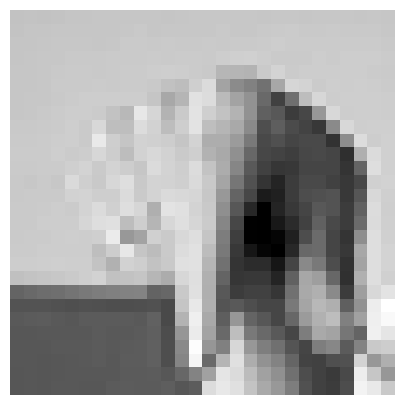

The predicted value is: q


In [54]:
#Test and display model prediction results
rnd_idx = np.random.randint(len(y_test))
print(f'The image displayed represents: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))
pred=predict(x_test_tensor[rnd_idx].reshape(1, -1), model2)
print(f'The predicted value is: {alphabet[pred]}')